In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
import os
import pretrainedmodels
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from fastai.callbacks import *
np.random.seed(0)

# Data import

In [3]:
IMG_PATH = DATA_PATH

In [4]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,0,5.1,3.5,1.4,0.2,0
1,1,4.9,3.0,1.4,0.2,0
2,2,4.7,3.2,1.3,0.2,0
3,3,4.6,3.1,1.5,0.2,0
4,4,5.0,3.6,1.4,0.2,0


In [25]:
train_df.target = train_df.target.sample(frac=1).values  # Randomise targets

In [26]:
train_df.head()

,image_name,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,0,5.1,3.5,1.4,0.2,1
1,1,4.9,3.0,1.4,0.2,1
2,2,4.7,3.2,1.3,0.2,2
3,3,4.6,3.1,1.5,0.2,2
4,4,5.0,3.6,1.4,0.2,1


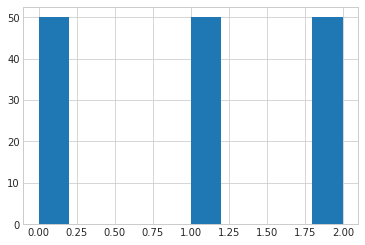

In [27]:
train_df.target.hist()

In [28]:
len(train_df[train_df.target==0])/len(train_df), len(train_df[train_df.target==1])/len(train_df)

(0.3333333333333333, 0.3333333333333333)

In [29]:
size = 224

In [30]:
train_df.head()

,image_name,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,0,5.1,3.5,1.4,0.2,1
1,1,4.9,3.0,1.4,0.2,1
2,2,4.7,3.2,1.3,0.2,2
3,3,4.6,3.1,1.5,0.2,2
4,4,5.0,3.6,1.4,0.2,1


In [31]:
data = ImageDataBunch.from_df(df=train_df, label_col='target', fn_col='image_name',
                              bs=16, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=IMG_PATH/'images', folder='train', suffix='.png').normalize(imagenet_stats)

In [32]:
data

ImageDataBunch;

Train: LabelList (120 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,2,1,2,1
Path: ../data/images;

Valid: LabelList (30 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,2,2,2,1
Path: ../data/images;

Test: None

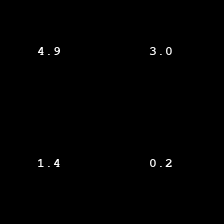

In [33]:
data.train_ds[0][0]

# Model training

In [34]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [35]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


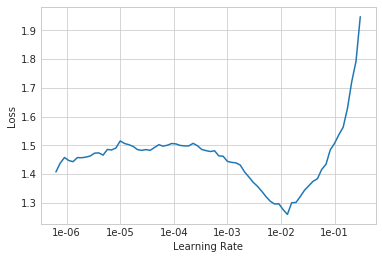

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.513104,1.196255,0.433333,00:01
1,1.416297,1.154800,0.366667,00:01
2,1.265291,1.501599,0.300000,00:01
3,1.113833,1.483318,0.300000,00:01
4,0.989873,2.472028,0.300000,00:01
5,0.875826,3.302248,0.300000,00:01
6,0.774770,3.253957,0.300000,00:01
7,0.689282,2.962043,0.300000,00:01
8,0.622605,2.884543,0.300000,00:01
9,0.561892,2.323120,0.333333,00:01


In [38]:
learn.save('stage-1')

In [39]:
learn.unfreeze()

In [40]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


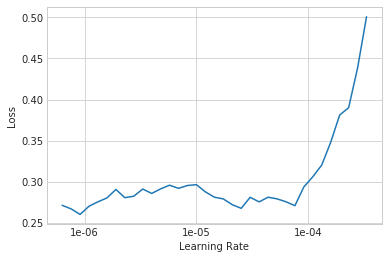

In [41]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(10, max_lr=slice(1e-8,1e-5),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best', mode='max')])

epoch,train_loss,valid_loss,accuracy,time
0,0.266150,2.054153,0.266667,00:01
1,0.391322,1.936845,0.300000,00:01
2,0.355843,1.968077,0.233333,00:01
3,0.360768,2.008808,0.200000,00:01
4,0.330269,2.014826,0.233333,00:01
5,0.313097,2.031458,0.233333,00:01
6,0.320430,2.035213,0.233333,00:01
7,0.316637,2.029858,0.233333,00:01
8,0.307340,2.031368,0.233333,00:01
9,0.302913,2.015195,0.233333,00:01


Better model found at epoch 0 with accuracy value: 0.2666666805744171.
Better model found at epoch 1 with accuracy value: 0.30000001192092896.


Model can't learn when the targets are randomised, indicating that the model really is actually learning something from the data